In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

# Positive Unlabelled Learning Example

## Generate data sets of positive and negative training and validation examples.

In [2]:
np.random.seed(42)

# initialize dataframes
df_p = pd.DataFrame()
df_n = pd.DataFrame()
df_p_val = pd.DataFrame()
df_n_val = pd.DataFrame()

# number of points and data distributions
n = 1000
mean1 = 5
mean2 = 10
std1 = 2
std2 = 2

# positive data
df_p['X'] = np.random.normal(mean1, std1, n)
df_p['Y'] = np.random.normal(mean1, std1, n)
df_p['Class'] = 1

# negative data
df_n['X'] = np.random.normal(mean2, std2, n)
df_n['Y'] = np.random.normal(mean2, std2, n)
df_n['Class'] = 0

# validation data
n_val = 200
df_p_val['X'] = np.random.normal(mean1, std1, n_val)
df_p_val['Y'] = np.random.normal(mean1, std1, n_val)
df_p_val['Class'] = 1
df_n_val['X'] = np.random.normal(mean2, std2, n_val)
df_n_val['Y'] = np.random.normal(mean2, std2, n_val)
df_n_val['Class'] = 0

# concatinate dataframes
df_val = pd.concat([df_p_val, df_n_val], ignore_index=True)
df = pd.concat([df_p, df_n], ignore_index=True)

## Create Lablelled-Unlabelled data set
From the previously created positive examples, 50% are now considered labeled. The negative examples and remaining 50% of positive examples are considered unlabelled.

Now some we are looking at the data set as either positive or unlabelled.  If it is unlabelled, we don't know if the data is belonging  to a positive or negative class.

In [3]:
m = int(n * 0.5)
ind = df[df['Class'] == 1].sample(m).index
df['Labeled'] = 0
df['Labeled'][ind] = 1

This is what the data looks like.

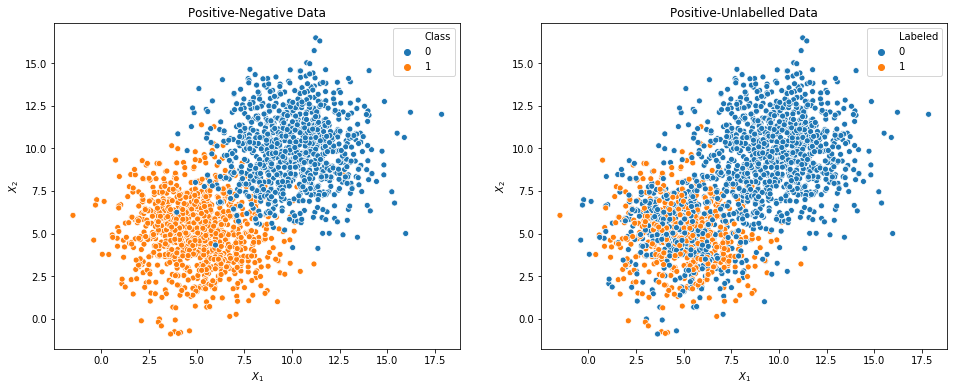

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

sns.scatterplot(df.X, df.Y, hue=df.Class, ax=ax[0])
ax[0].set_title('Positive-Negative Data')
ax[0].set_xlabel("$X_1$")
ax[0].set_ylabel("$X_2$")

sns.scatterplot(df.X, df.Y, hue=df.Labeled, ax=ax[1])
ax[1].set_title('Positive-Unlabelled Data')
ax[1].set_xlabel("$X_1$")
ax[1].set_ylabel("$X_2$");

## Positive-Negative Classifier
Here we will get a generate a baseline classifier of the positive-negative data.  This will act as an "optimal" classifier and we will try to replicate these results when we classify the positive-unlabelled data.

Keep in mind that any machine learning classifier does not find the optimal solution.  We simply refer to this classifier as "optimal" since it knows which data points are in reality positive or negative.

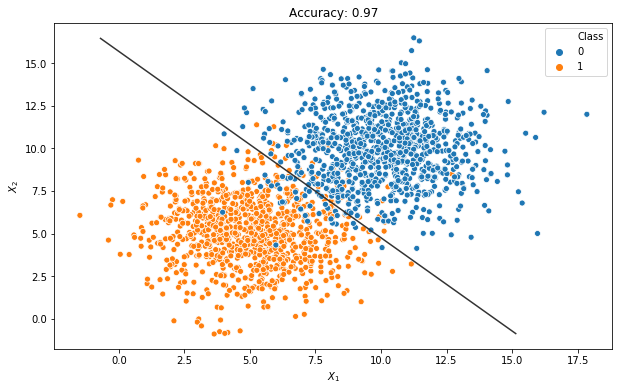

In [5]:
X_train_PN = df[['X', 'Y']]
y_train_PN = df.Class
X_test = df_val[['X', 'Y']]
y_test = df_val.Class

lr_PN = LogisticRegression()
lr_PN.fit(X_train_PN, y_train_PN)

y_pred_PN = lr_PN.predict(X_test)
y_probs_PN = lr_PN.predict_proba(X_test)
acu_PN = lr_PN.score(X_test, y_test)

xx, yy = np.mgrid[np.min(df.X):np.max(df.X):.02, np.min(df.Y):np.max(df.Y):.02]
grid = np.c_[xx.ravel(), yy.ravel()]
probs_PN = lr_PN.predict_proba(grid)[:, 1].reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(df.X, df.Y, hue=df.Class, ax=ax)
ax.contour(xx, yy, probs_PN, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title('Accuracy: {}'.format(acu_PN))
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$");

## Naïve Positive-Unlabelled Classifier
Let's see what will happen if we try the same approach above on a the positive-unlabelled data.  Keep in mind, we have examples we know are positive, and we have other examples in which we don't know if they are positive or negative.

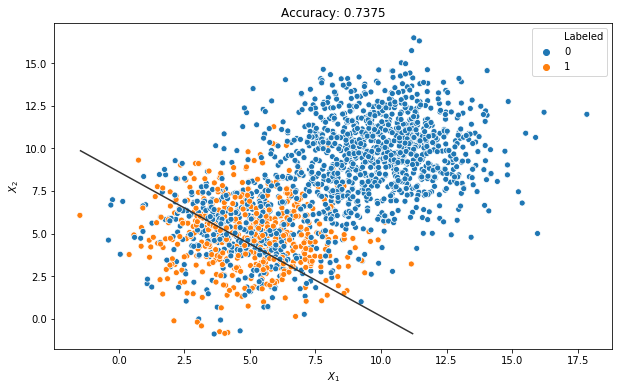

In [6]:
X_train_PU = df[['X', 'Y']]
y_train_PU = df.Labeled
lr_PU = LogisticRegression()
lr_PU.fit(X_train_PU, y_train_PU)

y_pred_PU = lr_PU.predict(X_test)
y_probs_PU = lr_PU.predict_proba(X_test)
acu_PU = lr_PU.score(X_test, y_test)

c = np.mean(y_probs_PU[:n_val, 1])

probs_PU = lr_PU.predict_proba(grid)[:, 1].reshape(xx.shape)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(df.X, df.Y, hue=df.Labeled, ax=ax)
ax.contour(xx, yy, probs_PU, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title('Accuracy: {}'.format(acu_PU))
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$");

We are calculating the accuracy score based on the underlying Positive-Negative labels, not the Positive-Unlabelled labels. So, when 50% of the positive examples were unlabelled, the classifier achieved 74% accuracy, far worse than the 97% achieved earlier.  We will call this naïve positive-unlabelld classifier $g(x)$.

The $c$ value outlined in $[1]$ is the constant probability that a positive example is labeled.  From the Positive-Unlabelled set, this can be approximated using the following formula,

<center>
    $$ c=p(s=1|y=1)
    $$,
</center>

where $s=1$ if the data is labeled and $y=1$ if an unlabeld example is positive.  We can then modify the classifier $f(x)$ to calculate a new positive-unlabelled classifier,

<center>
    $$
    f(x) = g(x)/c
    $$.
</center>

In [7]:
c = np.mean(y_probs_PU[:n_val, 1])
print('Estimated c value: {:.3f}'.format(c))

Estimated c value: 0.487


## New Positive-Unlabelled Classifier

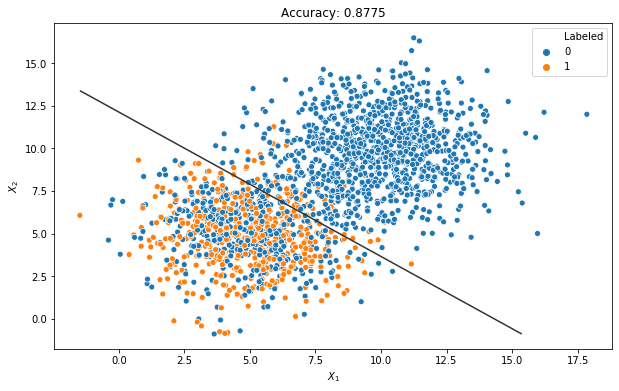

In [8]:
y_probs_PUL = y_probs_PU[:, 1] / c
y_pred_PUL = np.around(y_probs_PUL)
acu_PUL = accuracy_score(y_pred_PUL, y_test)

fig, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(df.X, df.Y, hue=df.Labeled, ax=ax)
ax.contour(xx, yy, probs_PU/c, levels=[.5], cmap="Greys", vmin=0, vmax=.6)
ax.set_title('Accuracy: {}'.format(acu_PUL))
ax.set_xlabel("$X_1$")
ax.set_ylabel("$X_2$");

We see that the modified positive-unlabelled classifier improves the accuracy from 74% to 87%, a significant improvement.

## Digging Deeper
We can now dig a bit deeper to understand when this positive-unlabelled learning is most valuable.  In the example above, we let 50% of the positives be unlabelled.  But what if this proportion is 20% or 80%?  We can repeat this experiment with various proportions of known positives and see how the classifier responds.

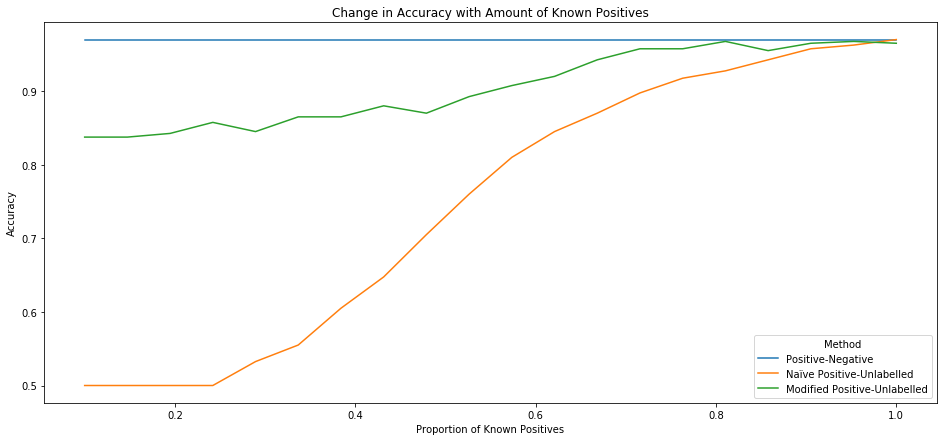

In [9]:
PNs = []
PUs = []
PULs = []

splits = np.linspace(0.1, 1, 20)

for split in splits:
    
    # determine number of positives to be labelled/unlabelled
    m = int(n * split)

    ind = df[df['Class'] == 1].sample(m).index
    df['Labeled'] = 0
    df['Labeled'][ind] = 1

    # Naïve Positive-Unlabelled

    X_train_PU = df[['X', 'Y']]
    y_train_PU = df.Labeled
    lr_PU = LogisticRegression()
    lr_PU.fit(X_train_PU, y_train_PU)

    y_pred_PU = lr_PU.predict(X_test)
    y_probs_PU = lr_PU.predict_proba(X_test)
    acu_PU = lr_PU.score(X_test, y_test)

    c = np.mean(y_probs_PU[:n_val, 1])

    # Modified Positive-Unlabelled

    y_probs_PUL = y_probs_PU[:, 1] / c
    y_pred_PUL = np.around(y_probs_PUL)
    acu_PUL = accuracy_score(y_pred_PUL, y_test)
    
    PNs.append(acu_PN)
    PUs.append(acu_PU)
    PULs.append(acu_PUL)

fig, ax = plt.subplots(figsize=(16, 7))    

sns.lineplot(x=splits, y=PNs, ax=ax)
sns.lineplot(x=splits, y=PUs, ax=ax)
sns.lineplot(x=splits, y=PULs, ax=ax)

ax.set_title('Change in Accuracy with Amount of Known Positives')
ax.set_xlabel('Proportion of Known Positives')
ax.set_ylabel('Accuracy')
plt.legend(title='Method', labels=['Positive-Negative', 
                                   'Naïve Positive-Unlabelled', 
                                   'Modified Positive-Unlabelled']);

If we look at the distance between the 'Naïve Positive-Unlabelled' and 'Modified Positive-Unlabelled' curves, we see that the Modified Positive-Unlabelled approach is most valuable when there is a large number of positives that are unlabelled.  As the proportion of known positives increases, the data approaches the positive-negative distribution and therefore the Naïve Positive-Unlabelled classifier approaches the optimal classifier.  

Nevertheless, the Modified Positive-Unlabelled classifier outperforms the Naïve Positive-Unlabelled classifier in all known positive proportions.

## Thanks for reading!


### References

$[1]$ Elkan, C., & Noto, K. (2008, August). Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining (pp. 213-220).